In [1]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions
from Bio.PDB.Polypeptide import one_to_three
from Bio.PDB.Polypeptide import three_to_one
from Bio.PDB.PDBParser import PDBParser
from pyCodeLib import *
# from small_script.myFunctions import *
sys.path.insert(0, "/Users/weilu/openmmawsem")
from helperFunctions.myFunctions import *
from collections import defaultdict
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})

In [3]:
# pre = "/Users/weilu/Research/server_backup/feb_2019/jan_optimization/gammas/"
# pre = "/Users/weilu/Research/server/april_2019/optimization_test/gammas/"
pre = "/Users/weilu/Research/server/sep_2019/peptide_optimization_trial_7_larger_set/optimization/gammas/"
trial_name = "trial_6"
# cutoff = 200


In [5]:
gamma_file_name = "/Users/weilu/Research/server/sep_2019/peptide_optimization/saved_gammas/original_gamma"
original_gamma = np.loadtxt(gamma_file_name)
# we want to impose additional contraint so that A' * gamma = constnat.(-562.23)
cutoff_list = [100, 200, 300, 400, 500]
for cutoff_i in cutoff_list:
    A, A_prime, filtered_gamma, filtered_B_inv = get_filtered_gamma(pre, cutoff_i)
    c = np.dot(A_prime, original_gamma)
    B_inv = filtered_B_inv
    lambda_2 = (A_prime.dot(B_inv).dot(A) - c) / (A_prime.dot(B_inv).dot(A_prime) )
    gamma_new = B_inv.dot(A-A_prime*lambda_2)
    # impose A'gamma
    save_gamma_pre = "/Users/weilu/Research/server/sep_2019/saved_gammas/"
    np.savetxt(f"{save_gamma_pre}/{trial_name}_cutoff{cutoff_i}_impose_Aprime_constraint", gamma_new)

In [4]:
def get_filtered_gamma(pre, cutoff):
    # pp = "cath-dataset-nonredundant-S20Clean_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0"
    # pp = "proteins_name_list_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0phi_burial_well4.0"
    pp = f"protein_list_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0phi_burial_well4.0"

    A_name = pp + "_A"
    B_name = pp + "_B"
    B_filtered_name = pp + "_B_filtered"
    P_name = pp + "_P"
    Gamma_name = pp + "_gamma"
    Gamma_filtered_name = pp + "_gamma_filtered"
    Lamb_name = pp + "_lamb"
    Lamb_filtered_name = pp + "_lamb_filtered"

    A = np.loadtxt(pre+A_name)
    B = np.loadtxt(pre+B_name)
    B_filtered = np.loadtxt(pre+B_filtered_name, dtype=complex, converters={
                               0: lambda s: complex(s.decode().replace('+-', '-'))})
    Gamma = np.loadtxt(pre+Gamma_name)
    Gamma_filtered = np.loadtxt(pre+Gamma_filtered_name, dtype=complex, converters={
                               0: lambda s: complex(s.decode().replace('+-', '-'))})
    Lamb = np.loadtxt(pre+Lamb_name, dtype=complex, converters={
                               0: lambda s: complex(s.decode().replace('+-', '-'))})
    Lamb_filtered = np.loadtxt(pre+Lamb_filtered_name, dtype=complex, converters={
                               0: lambda s: complex(s.decode().replace('+-', '-'))})

    half_B_name = pp + "_half_B"
    half_B = np.loadtxt(pre+half_B_name)
    other_half_B_name = pp + "_other_half_B"
    other_half_B = np.loadtxt(pre+other_half_B_name)
    std_half_B_name = pp + "_std_half_B"
    std_half_B = np.loadtxt(pre+std_half_B_name)


    # pre = "/Users/weilu/Research/server/april_2019/"
    location = pre + "../../phis/protein_list_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0phi_burial_well4.0_phi_decoy_summary.txt"
    A_prime = np.loadtxt(location)
    
    lamb, P = np.linalg.eig(B)
    lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
    filtered_lamb = np.copy(lamb)
    cutoff_mode = cutoff
    filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb, 
                                                                       cutoff_mode, P)
    filtered_gamma = np.dot(filtered_B_inv, A)
    filtered_B = np.linalg.inv(filtered_B_inv)

    return A, A_prime, filtered_gamma, filtered_B_inv



In [7]:
cutoff = 300
A, A_prime, filtered_gamma, filtered_B_inv = get_filtered_gamma(pre, cutoff)

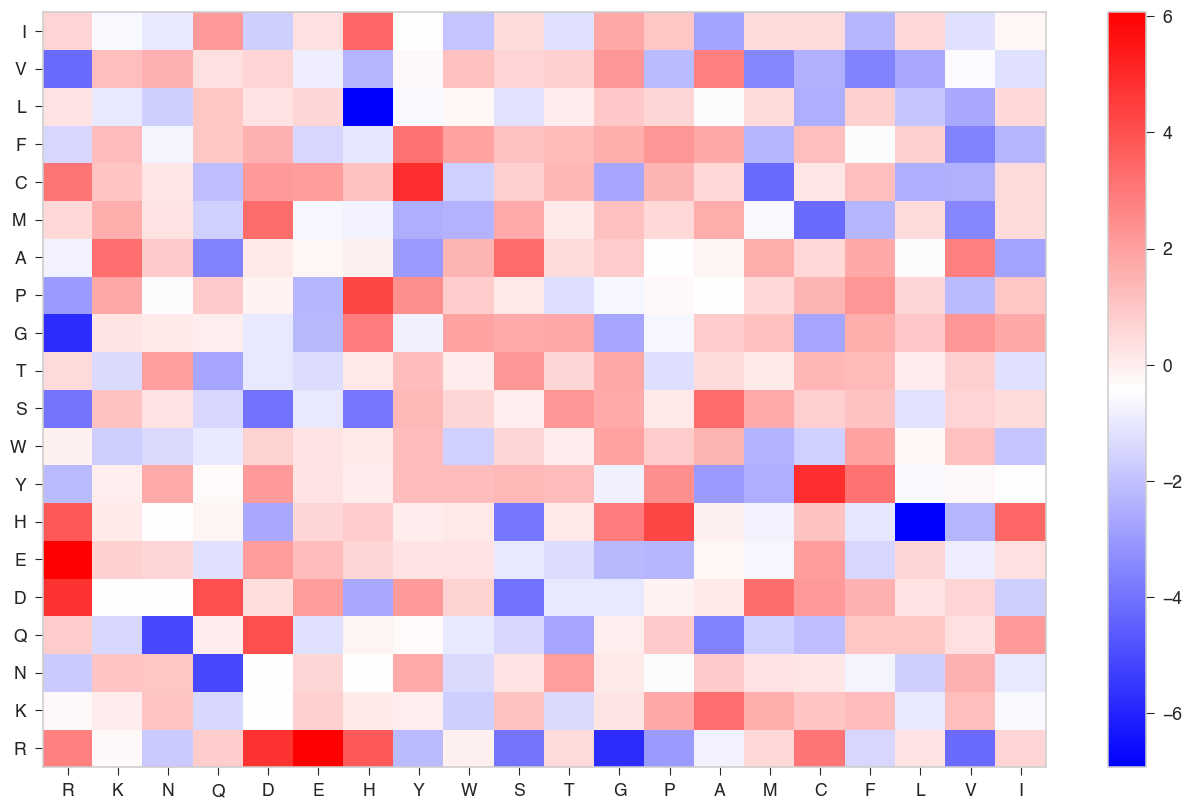

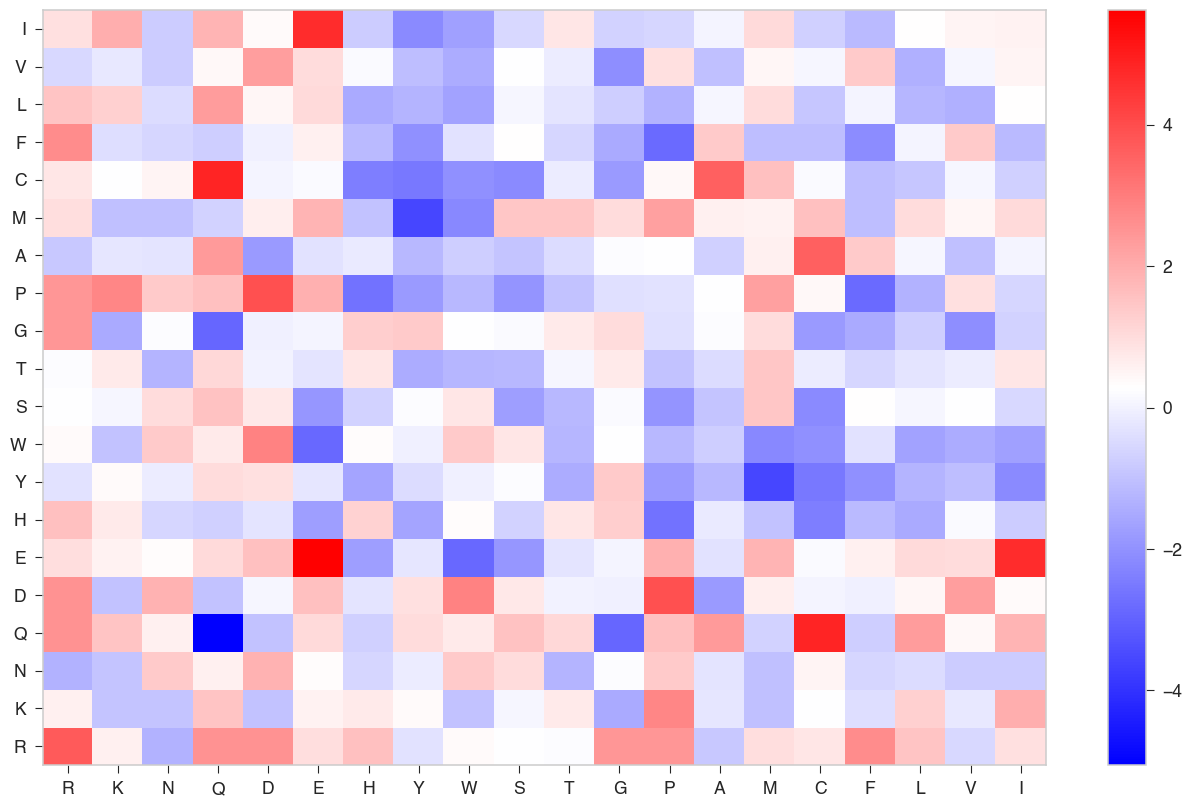

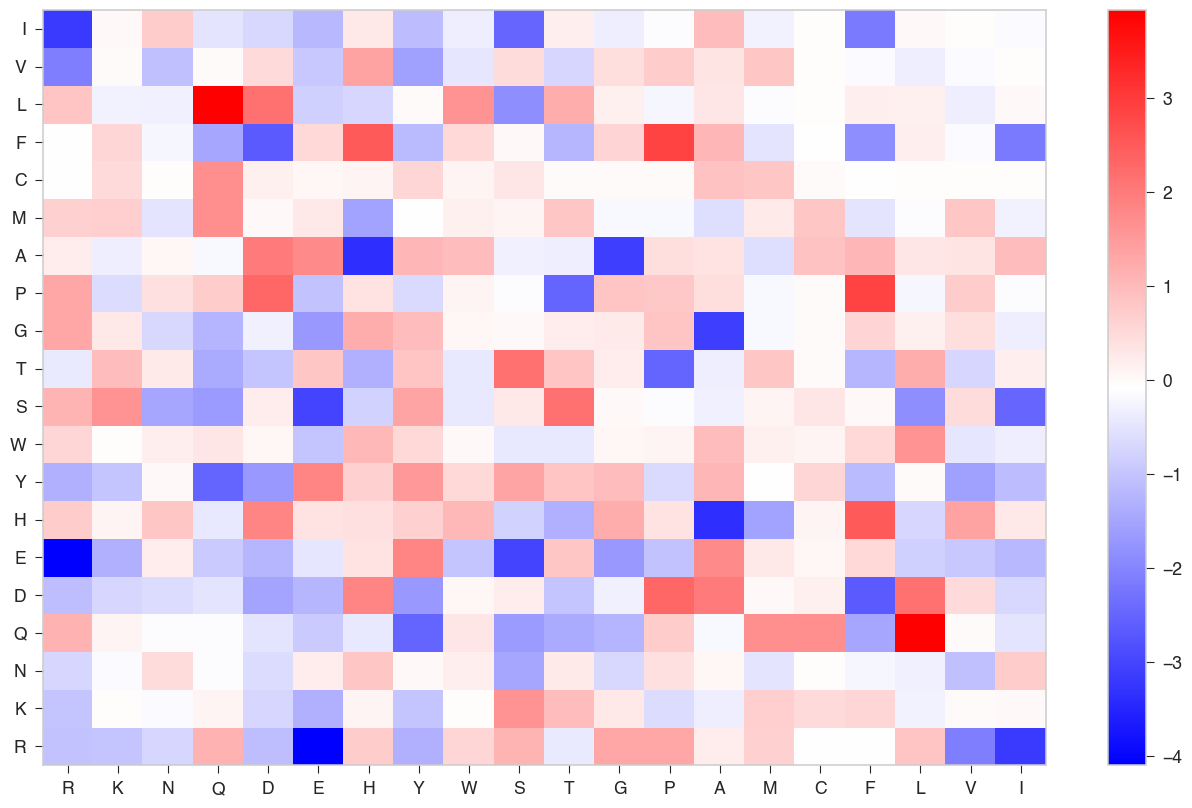

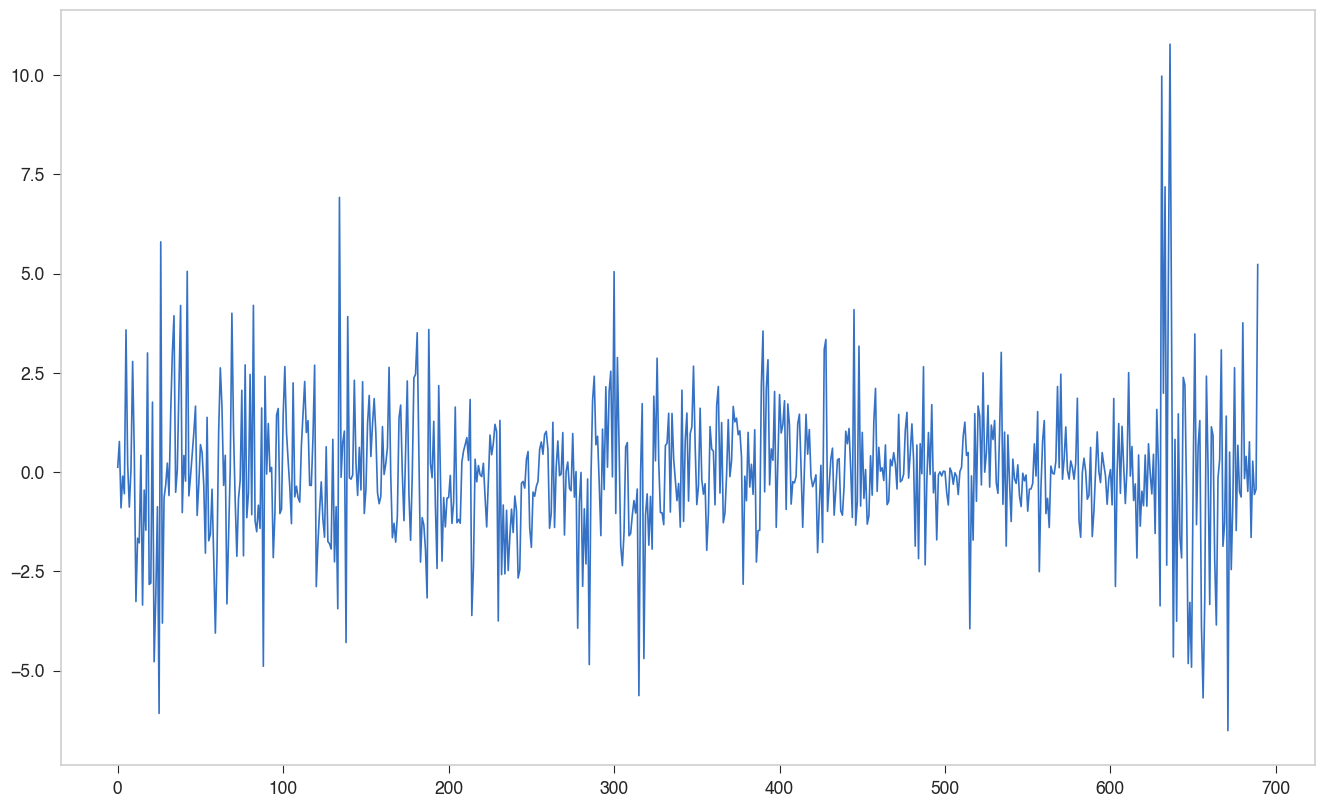

In [9]:
plot_contact_well(filtered_gamma[:210], inferBound=True)
plot_contact_well(filtered_gamma[210:420], inferBound=True)
plot_contact_well(filtered_gamma[420:], inferBound=True)
plt.plot(filtered_gamma)

In [10]:
# maximum difference between loaded and computed is 1e-5.
max(lamb-Lamb)

(1.417108159994327e-05+0j)

In [13]:
save_gamma_pre = "/Users/weilu/Research/server/sep_2019/saved_gammas/"
np.savetxt(f"{save_gamma_pre}/{trial_name}_cutoff{cutoff}", filtered_gamma)

In [8]:
# os.chdir('/Users/weilu/opt/notebook/Optimization')

In [45]:
gamma_file_name = "/Users/weilu/Research/server/sep_2019/peptide_optimization/saved_gammas/original_gamma"
original_gamma = np.loadtxt(gamma_file_name)

In [46]:
np.dot(A_prime, original_gamma)

-551.780941107728

In [58]:
gamma_file_name = "/Users/weilu/Research/server/sep_2019/peptide_optimization/saved_gammas/original_gamma"
original_gamma = np.loadtxt(gamma_file_name)
# we want to impose additional contraint so that A' * gamma = constnat.(-562.23)
cutoff_list = [100, 200, 300, 400, 500]
for cutoff_i in cutoff_list:
    A, A_prime, filtered_gamma, filtered_B_inv = get_filtered_gamma(pre, cutoff_i)
    c = np.dot(A_prime, original_gamma)
    B_inv = filtered_B_inv
    lambda_2 = (A_prime.dot(B_inv).dot(A) - c) / (A_prime.dot(B_inv).dot(A_prime) )
    gamma_new = B_inv.dot(A-A_prime*lambda_2)
    # impose A'gamma
    save_gamma_pre = "/Users/weilu/Research/server/sep_2019/saved_gammas/"
    np.savetxt(f"{save_gamma_pre}/{trial_name}_cutoff{cutoff_i}_impose_Aprime_constraint", gamma_new)

In [48]:
np.dot(A_prime, gamma_new)

-551.7809411077282

In [28]:
def output_E_decoy(hamiltonian, training_set_file, gamma_file_name, training_decoy_method, num_decoys, test_set_file=None, test_decoy_method=None, use_filtered_gammas=False, **kwargs):
    if test_set_file is None:
        test_set_file = training_set_file
    if test_decoy_method is None:
        test_decoy_method = training_decoy_method
    test_set = read_column_from_file(test_set_file, 1)
    z_scores = []
    e_natives = []
    e_mgs = []
    e_mg_stds = []
    e_decoys = []
    names = []
    for i, protein in enumerate(test_set):
#         print(i, protein)
        # print(protein, hamiltonian, training_set_file, gamma_file_name, test_decoy_method, num_decoys, use_filtered_gammas)
        e_native, e_decoy = evaluate_hamiltonian_wei(
            protein, hamiltonian, training_set_file, gamma_file_name, test_decoy_method, num_decoys, use_filtered_gammas, outputDecoy=True, **kwargs)
        # print(protein, z)
        e_natives.append(e_native)
        e_decoys.append(e_decoy)
        names.append(protein)
    return names, e_natives, e_decoys

do = os.system

In [25]:
# pre = "/Users/weilu/Research/server/sep_2019/peptide_optimization_trial_5/optimization/gammas/"
os.chdir(f"{pre}/..")
# gamma_file_name = "gamma_iter1_combined_mar06.dat"
# gamma_file_name = "/Users/weilu/Research/server/sep_2019/peptide_optimization/saved_gammas/cutoff100"
gamma_file_name = f"{save_gamma_pre}/{trial_name}_cutoff{cutoff}_impose_Aprime_constraint"

names, e_natives, e_decoys = output_E_decoy("phi_list.txt", "protein_list", gamma_file_name, "shuffle", 1000, mode=0)



In [30]:
figure_folder = "/Users/weilu/Dropbox/Sep28_figures"
do(f"mkdir -p {figure_folder}")
for name, e_native, e_decoy in zip(names, e_natives, e_decoys):
    # print(name)
    plt.figure()
    _ = plt.hist(e_decoy, bins=50)
    plt.vlines(e_native, ymin=0, ymax=100, color="red")
    _ = plt.title(name)
    plt.savefig(f"{figure_folder}/{name}.png")
    plt.close()

In [31]:
os.chdir(f"{pre}/..")
# gamma_file_name = "gamma_iter1_combined_mar06.dat"
# gamma_file_name = "/Users/weilu/Research/server/sep_2019/peptide_optimization/saved_gammas/cutoff100"
gamma_file_name = f"{save_gamma_pre}/{trial_name}_cutoff{cutoff}_impose_Aprime_constraint"

data = validate_hamiltonian_wei("phi_list.txt", "protein_list", gamma_file_name, "shuffle", 1000, mode=0)
data


0 4.479292940298622


,Protein,Z_scores,E_native,E_mgs,Std_mg
0,1BD2,4.479293,-554.211510,-524.888912,6.546256
1,2JCC,7.713614,-601.915889,-548.906966,6.872125
2,1AO7,6.201762,-575.152737,-534.523389,6.551259
3,1LP9,7.940080,-607.913892,-549.673048,7.335045
4,3QDJ,6.640863,-627.896671,-583.640952,6.664152
5,3GSN,4.697146,-568.016980,-539.964369,5.972268
6,1QRN,5.659047,-614.717161,-580.601377,6.028539
7,3PWP,6.811802,-554.133964,-515.025196,5.741325
8,5W1W,3.169055,-537.147529,-511.567986,8.071663
9,1QSE,6.938600,-596.708635,-557.415004,5.663049
